AiApp Miniproject; Leonie Däullary, Ruwen Frick

The main goal is to train a network to detect alzeheimers disease in brain MRI images. The data can be found here: https://www.kaggle.com/datasets/sachinkumar413/alzheimer-mri-dataset

Needed Packages

In [ ]:
pip install opendatasets tensorflow matplotlib seaborn

Imports

In [58]:
import tensorflow

from tensorflow.math import confusion_matrix
from keras import Sequential
from keras_preprocessing.image import ImageDataGenerator
from keras.layers.convolutional import Conv2D
from keras.layers import Flatten, Dense, MaxPooling2D

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sb
from numpy import argmax

import opendatasets as od
import os
from pathlib import Path, PurePath

Dowloading the Data

The dataset is hosted on Kaggle. When executing the following cell you will be asked for your Kaggle credentials. These can be acquired by following below steps:

1. Sign in to https://kaggle.com/ or register a new account, then click on your profile picture on the top right and select "My Account" from the menu.

2. Scroll down to the "API" section and click "Create New API Token". This will download a file kaggle.json with the following contents:
    {"username":"YOUR_KAGGLE_USERNAME","key":"YOUR_KAGGLE_KEY"}

In [ ]:
dataset_url = 'https://www.kaggle.com/sachinkumar413/alzheimer-mri-dataset'
od.download(dataset_url)

path = Path(".", 'alzheimer-mri-dataset', 'Dataset').absolute()
print(f"Data stored at: {path}")

classes = [dir for dir in sorted(os.listdir(path))]

mild_path = Path(path, classes[0])
moderate_path = Path(path, classes[1])
non_path = Path(path, classes[2])
verymild_path = Path(path, classes[3])

Print metadata of downloaded dataset

In [ ]:
for dirpath, dirnames, filenames in os.walk(path):
    class_name = PurePath(dirpath).name
    if class_name != 'Dataset':
        print(f'{len(filenames)} images in class {class_name}')

Print some examples

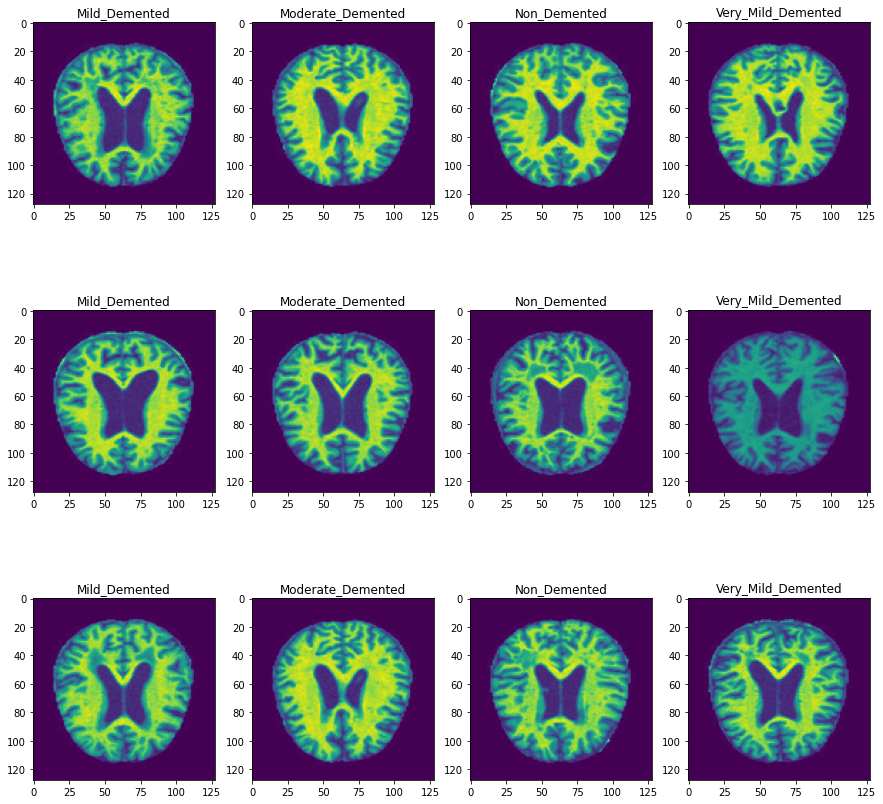

In [59]:
all_imgs = []

for i in range(2, 5): 
    all_imgs.append(mpimg.imread(Path(mild_path, 'mild_' + str(i) + '.jpg')))
    all_imgs.append(mpimg.imread(Path(moderate_path, 'moderate_' + str(i) + '.jpg')))
    all_imgs.append(mpimg.imread(Path(non_path, 'non_' + str(i) + '.jpg')))
    all_imgs.append(mpimg.imread(Path(verymild_path, 'verymild_' + str(i) + '.jpg')))

plt.figure(figsize=(15, 15))

for index in range(1, len(all_imgs) + 1):
    plt.subplot(3, 4, index)
    plt.imshow(all_imgs[index - 1])
    plt.title(classes[(index - 1) % len(classes)])

plt.show()

Preprocessing and Data Augmentation

In [60]:
# Data generation and augmentation parameters
image_size = (128, 128)
horizontal_flip = True
color_mode = 'rgb'
zoom_range = 0.05
rotation_range = 10
shear_range = 0.1
batch_size  = 64
validation_split = 0.15

train_data_generator = ImageDataGenerator(
    horizontal_flip = horizontal_flip,
    zoom_range = zoom_range,
    rotation_range = rotation_range,
    shear_range = shear_range,
    validation_split = validation_split
)

valid_data_generator = ImageDataGenerator(
    validation_split = validation_split
)

train_data = train_data_generator.flow_from_directory(
    path,
    target_size = image_size,
    color_mode = color_mode,
    batch_size  = batch_size,
    subset = 'training'
)

valid_data = valid_data_generator.flow_from_directory(
    path,
    target_size = image_size,
    color_mode = color_mode,
    batch_size  = batch_size,
    subset = 'validation'
)

Found 5441 images belonging to 4 classes.
Found 959 images belonging to 4 classes.


Building the models

In [61]:
deep_model = Sequential([
  Conv2D(64, (4, 4), activation = 'relu', input_shape = (128, 128, 3)),
  MaxPooling2D((3, 3)),
  Conv2D(32, (3, 3), activation = 'relu'),
  MaxPooling2D((2, 2)),
  Conv2D(32, (2, 2), activation = 'relu'),
  MaxPooling2D((2, 2)),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(64, activation='relu'),
  Dense(len(classes), activation='softmax'),
])

shallow_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(len(classes), activation='softmax'),
])

In [62]:
deep_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 125, 125, 64)      3136      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 41, 41, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 39, 39, 32)        18464     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 19, 19, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 18, 18, 32)        4128      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 9, 9, 32)        

In [63]:
shallow_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 57600)             0         
                                                                 
 dense_8 (Dense)             (None, 32)               

Compile, fit and test models

In [64]:
deep_model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

shallow_model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [65]:
deep_history = deep_model.fit(
    train_data,
    epochs = 5,
    validation_data = valid_data,
)
deep_acc = deep_model.evaluate(valid_data)[1]
deep_predictions = argmax(deep_model.predict(valid_data), axis = 1)

Epoch 1/5
86/86 [==============================] - 58s 664ms/step - loss: 3.0271 - accuracy: 0.4823 - val_loss: 1.0556 - val_accuracy: 0.5026
Epoch 2/5
86/86 [==============================] - 54s 625ms/step - loss: 0.9689 - accuracy: 0.5372 - val_loss: 1.0505 - val_accuracy: 0.5464
Epoch 3/5
86/86 [==============================] - 55s 644ms/step - loss: 0.9275 - accuracy: 0.5532 - val_loss: 1.1477 - val_accuracy: 0.4505
Epoch 4/5
86/86 [==============================] - 61s 713ms/step - loss: 0.9028 - accuracy: 0.5611 - val_loss: 1.2298 - val_accuracy: 0.3337
Epoch 5/5
15/15 [==============================] - 3s 190ms/step - loss: 1.1617 - accuracy: 0.4004


In [66]:
shallow_history = shallow_model.fit(
    train_data,
    epochs = 5,
    validation_data = valid_data,
)
shallow_acc = deep_model.evaluate(valid_data)[1]
shallow_predictions = argmax(shallow_model.predict(valid_data), axis = 1)

Epoch 1/5
86/86 [==============================] - 70s 814ms/step - loss: 57.8126 - accuracy: 0.4189 - val_loss: 1.0339 - val_accuracy: 0.5005
Epoch 2/5
86/86 [==============================] - 69s 798ms/step - loss: 1.0219 - accuracy: 0.4999 - val_loss: 1.0632 - val_accuracy: 0.5005
Epoch 3/5
86/86 [==============================] - 68s 792ms/step - loss: 1.0181 - accuracy: 0.5006 - val_loss: 1.0540 - val_accuracy: 0.5005
Epoch 4/5
86/86 [==============================] - 68s 794ms/step - loss: 1.0152 - accuracy: 0.4986 - val_loss: 1.0651 - val_accuracy: 0.5005
Epoch 5/5
15/15 [==============================] - 3s 174ms/step - loss: 1.1617 - accuracy: 0.4004


In [ ]:
deep_cm = confusion_matrix(deep_predictions, valid_data.classes)
shallow_cm = confusion_matrix(shallow_predictions, valid_data.classes)

Print results

In [ ]:
# print accuracy
print(f'Validation accuracy of deep model: {deep_acc}')
print(f'Validation accuracy of shallow model: {shallow_acc}')

In [ ]:
sns.heatmap(deep_cm, annot=True, fmt='d')

In [ ]:
sns.heatmap(shallow_cm, annot=True, fmt='d')

In [ ]:
# plot accuracy against epochs
plt.title('Accuracy')
plt.plot(deep_history.history['accuracy'], label= 'deep_accuracy')
plt.plot(deep_history.history['val_accuracy'], label = 'deep_val_accuracy')
plt.plot(shallow_history.history['accuracy'], label= 'shallow_accuracy')
plt.plot(shallow_history.history['val_accuracy'], label = 'shallow_val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 0.8)
plt.xlim(1, 5)
plt.legend(loc='lower right')

In [ ]:
# plot accuracy against epochs
plt.title('Loss')
plt.plot(deep_history.history['loss'], label= 'deep_loss')
plt.plot(shallow_history.history['loss'], label= 'shallow_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0.6, 1)
plt.xlim(1, 5)
plt.legend(loc='lower right')

Discussion


Performance overall is poor. The models accuracies are almost identical. Both models have lower validation accuracy than training accuracy, which might indicate overfitting. The shallow models loss is steadily decreasing, while the deep models stays fairly consistent with more epochs. The confusion matrix shows that the accuracy for each class is approximatly 0.5. This indicates that a coin toss is about as well suited for this task as these networks.

Investigating the rather poor performance needs further investigation that is beyond the scope of this excercise.